In [8]:
from tensorflow.keras.models import load_model
from glob import glob
from sklearn.preprocessing import StandardScaler
import mne
from matplotlib import pyplot
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [9]:
model_paths = ['models/global_model.h5','models/local_model_0.h5','models/local_model_1.h5','models/local_model_2.h5','models/local_model_3.h5','models/local_model_4.h5','models/local_model_5.h5','models/local_model_6.h5','models/local_model_7.h5','models/local_model_8.h5','models/local_model_9.h5']
models = [load_model(model_path) for model_path in model_paths]

In [10]:
all_files_path=glob('../test/*.edf')
print(len(all_files_path))
healthy_file_path=[i for i in all_files_path if  'H' in i.split('\\')[1]]
patient_file_path=[i for i in all_files_path if  'M' in i.split('\\')[1]]

print(len(healthy_file_path),len(patient_file_path))
def read_data(file_path):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    # Select a specific channel
    channel_to_keep = ['EEG Fp1-LE', 'EEG F3-LE', 'EEG C3-LE', 'EEG P3-LE', 'EEG O1-LE', 'EEG F7-LE', 'EEG T3-LE', 'EEG T5-LE', 'EEG Fz-LE', 'EEG Fp2-LE', 'EEG F4-LE', 'EEG C4-LE', 'EEG P4-LE', 'EEG O2-LE', 'EEG F8-LE', 'EEG T4-LE', 'EEG T6-LE', 'EEG Cz-LE', 'EEG Pz-LE']  
      
    # Replace with the name of the channel you want to keep
    raw.pick_channels(channel_to_keep)
    raw.set_eeg_reference()
    raw.filter(l_freq=30,h_freq=100)#1-4=delta, 4-8=theta, 8-12=alpha, 12-30=beta, 30-100=gamma
    epochs=mne.make_fixed_length_epochs(raw,duration=15,overlap=1)
    epochs=epochs.get_data()
    scaler = StandardScaler()
    data = scaler.fit_transform(epochs.reshape(-1,epochs.shape[-1])).reshape(epochs.shape)
    return data #trials,channel,length

18
9 9


In [11]:
%%capture
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [12]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
data_array=np.moveaxis(data_array,1,2)

9 9
18 18


In [13]:
acc = []
pre=[]
rec=[]
f1=[]
for i in range(1, len(models)+1):
    single_score = models[i-1].evaluate(data_array, label_array)
    acc.append(single_score[1])
    pre.append(single_score[2])
    rec.append(single_score[3])
    # f1sc=2*((single_score[2]*single_score[3])/(single_score[2]+single_score[3]))
    # f1.append(f1sc)

17/17 [==============================] - 1s 20ms/step - loss: 5.2240 - Accuracy: 0.5267 - precision: 0.5267 - recall: 1.0000 - auc: 0.4650         


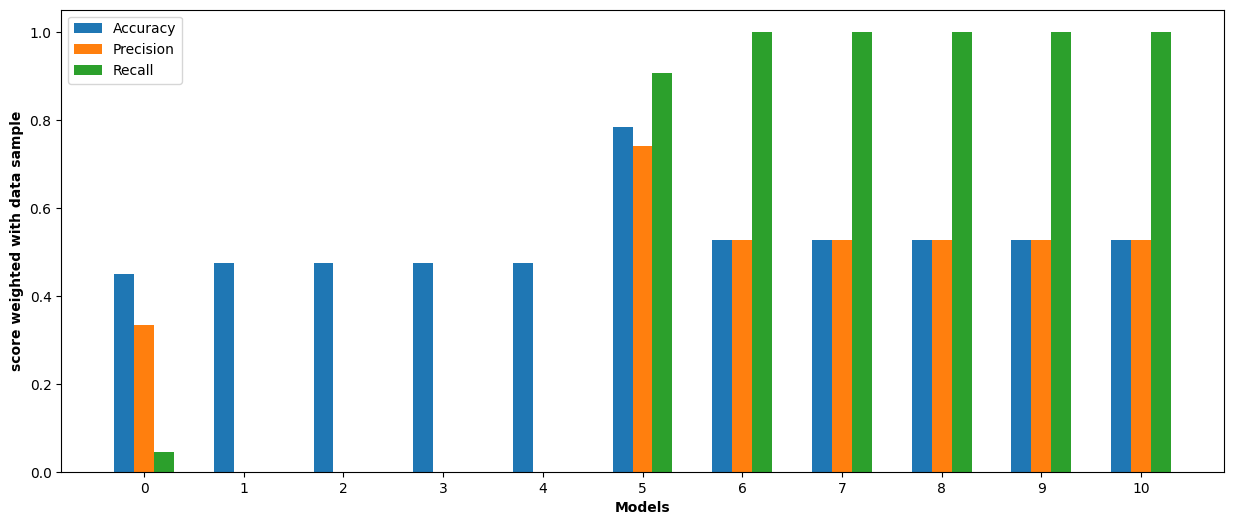

In [14]:
# Resize the plot
pyplot.figure(figsize=(15, 6))
# Bar width
bar_width = 0.2

# Set positions for bars on X-axis
r1 = np.arange(len(model_paths))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]
# Create the bar chart
pyplot.bar(r1, acc, width=bar_width, label='Accuracy')
pyplot.bar(r2, pre, width=bar_width, label='Precision')
pyplot.bar(r3, rec, width=bar_width, label='Recall')
# pyplot.bar(r4, f1_scores, width=bar_width, label='F1 Score')

# Add labels and title
pyplot.xlabel('Models', fontweight='bold')
pyplot.ylabel('score weighted with data sample', fontweight='bold')
pyplot.xticks([r + bar_width for r in range(11)], range(11))
pyplot.legend()

# Show the plot
pyplot.show()